In [ ]:
import time, psutil, os, resource

start_time = time.time()
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / (1024 ** 2) 

In [11]:
import os, time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE, RFECV, SelectKBest, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, FeatureAgglomeration, SpectralClustering

from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, silhouette_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, ParameterGrid, ValidationCurveDisplay, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, Normalization, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.neural_network import MLPClassifier

In [35]:
path_to_training_data = r"training_data_dates_over_years.gpkg"
training_data_layer_name = "stands_Training_data"

training_data = gpd.read_file(path_to_training_data, layer=training_data_layer_name)
training_data.head()

,fid_1,ID,XCOORD,YCOORD,HEIGHT,SPECIES,Shape_Length,Shape_Area,INV_UNIT,PAR_UNIT,...,NDBI_08-01_MEAN,NDBI_08-11_MEAN,NDBI_08-21_MEAN,NDBI_09-01_MEAN,NDBI_09-11_MEAN,NDBI_09-21_MEAN,NDBI_10-01_MEAN,NDBI_10-11_MEAN,NDBI_10-21_MEAN,geometry
0,2322012.0,67330,604767.870,6913829.000,20.592600,2.0,16.0,9.875,22454000,NaN,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,"MULTIPOLYGON (((604766.37 6913830.75, 604766.8..."
1,2322222.0,8147,604771.495,6913828.125,25.119101,2.0,19.5,14.375,22454001,NaN,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,"MULTIPOLYGON (((604771.37 6913830.5, 604771.87..."
2,2322523.0,8184,604776.995,6913824.375,25.944401,2.0,29.0,25.000,22454002,NaN,...,-0.464200,-0.455254,-0.471066,-0.486093,-0.484010,-0.482644,-0.478856,-0.436272,-0.433940,"MULTIPOLYGON (((604775.62 6913827.75, 604776.1..."
3,2322537.0,67317,604767.870,6913823.625,20.515301,2.0,17.0,10.375,22454003,NaN,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,"MULTIPOLYGON (((604769.12 6913825.75, 604769.3..."
4,2322718.0,8200,604771.870,6913822.875,25.156799,2.0,26.5,21.875,22454004,NaN,...,-0.477387,-0.463910,-0.473634,-0.486976,-0.487947,-0.489706,-0.464757,-0.411976,-0.405982,"MULTIPOLYGON (((604772.62 6913826.25, 604772.8..."


In [ ]:
#inspect timesteps
timesteps_per_polygon = training_data.groupby(["polygon_id","year"]).size()
counts = timesteps_per_polygon.reset_index()
print(counts[counts['year'] == 2019].mean())


In [36]:
lidar_ch1_features = training_data.filter(regex=r"^L_Ch1_.*")
lidar_ch2_features = training_data.filter(regex=r"^L_Ch2_.*")
lidar_ch3_features = training_data.filter(regex=r"^L_Ch3_.*")

s2_mosaic_features = training_data.filter(regex=r"^[A-Z]\d{2}_\d{2}")
s2_index_features = training_data.filter(regex=r"^[A-Z]{4}_")
lidar_features = pd.concat([lidar_ch1_features, lidar_ch2_features, lidar_ch3_features], axis=1)
y = training_data["SPECIES"]

In [7]:
s2_mosaic_features

,B02_04-01_MEAN,B02_04-11_MEAN,B02_04-21_MEAN,B02_05-01_MEAN,B02_05-11_MEAN,B02_05-21_MEAN,B02_06-01_MEAN,B02_06-11_MEAN,B02_06-21_MEAN,B02_07-01_MEAN,...,B12_07-21_MEAN,B12_08-01_MEAN,B12_08-11_MEAN,B12_08-21_MEAN,B12_09-01_MEAN,B12_09-11_MEAN,B12_09-21_MEAN,B12_10-01_MEAN,B12_10-11_MEAN,B12_10-21_MEAN
0,0.057997,0.054950,0.030469,0.020888,0.018375,0.022900,0.025905,0.016300,0.018700,0.017678,...,0.035344,0.036033,0.038383,0.033533,0.030233,0.027787,0.025340,0.030660,0.038727,0.040554
1,0.057997,0.054950,0.030469,0.020888,0.018375,0.022900,0.025905,0.016300,0.018700,0.017678,...,0.035344,0.036033,0.038383,0.033533,0.030233,0.027787,0.025340,0.030660,0.038727,0.040554
2,0.039575,0.054075,0.026147,0.018256,0.013969,0.020217,0.024829,0.015050,0.022783,0.019594,...,0.031973,0.032517,0.034658,0.029750,0.026317,0.023812,0.021307,0.026327,0.032249,0.033123
3,0.057997,0.054950,0.030469,0.020888,0.018375,0.022900,0.025905,0.016300,0.018700,0.017678,...,0.035344,0.036033,0.038383,0.033533,0.030233,0.027787,0.025340,0.030660,0.038727,0.040554
4,0.055930,0.052789,0.028937,0.018533,0.015633,0.021433,0.025007,0.015578,0.021033,0.018904,...,0.032986,0.030622,0.034139,0.031411,0.028044,0.025593,0.023142,0.028524,0.036221,0.038125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,0.032940,0.015158,0.027112,0.013313,0.018550,0.017972,0.020128,0.012867,0.022100,0.029944,...,0.041133,0.048167,0.044267,0.041300,0.037624,0.036017,0.034411,0.042956,0.017899,0.019981
3915,0.102334,0.007803,0.040160,0.020550,0.022250,0.031109,0.022691,0.015600,0.028233,0.039233,...,0.057140,0.058567,0.058233,0.053000,0.075467,0.061733,0.048000,0.058633,0.026903,0.029035
3916,0.032940,0.015158,0.027112,0.013313,0.018550,0.017972,0.020128,0.012867,0.022100,0.029944,...,0.041133,0.048167,0.044267,0.041300,0.037624,0.036017,0.034411,0.042956,0.017899,0.019981
3917,0.075602,0.008922,0.034982,0.016688,0.017712,0.022345,0.020022,0.014400,0.022533,0.033789,...,0.052400,0.053800,0.050667,0.047133,0.070833,0.054767,0.038700,0.049189,0.019916,0.022176


In [37]:
X_full = pd.concat([lidar_features, s2_mosaic_features, s2_index_features, training_data["HEIGHT"]], axis=1)
X_lidar = pd.concat([lidar_features, training_data["HEIGHT"]], axis=1)
X_without_index = pd.concat([lidar_features, s2_mosaic_features, training_data["HEIGHT"]], axis=1)

In [38]:
X_full['pixel_id'] = pd.factorize(X_full[s2_index_features.columns].apply(tuple, axis=1))[0]
X_without_index['pixel_id'] = pd.factorize(X_without_index[s2_mosaic_features.columns].apply(tuple, axis=1))[0]
groups = X_full['pixel_id']
X_full = X_full.drop(columns="pixel_id")
X_without_index.drop(columns="pixel_id")

,L_Ch1_VEG_Z95,L_Ch1_VEG_Z90,L_Ch1_VEG_Z85,L_Ch1_VEG_Z80,L_Ch1_VEG13_Z95,L_Ch1_VEG13_Z90,L_Ch1_VEG13_Z85,L_Ch1_VEG13_Z80,L_Ch1_X_VD,L_Ch1_X_ZP85,...,B12_08-01_MEAN,B12_08-11_MEAN,B12_08-21_MEAN,B12_09-01_MEAN,B12_09-11_MEAN,B12_09-21_MEAN,B12_10-01_MEAN,B12_10-11_MEAN,B12_10-21_MEAN,HEIGHT
0,19.0489,18.3825,18.0235,17.9863,19.1364,19.0489,18.3825,18.1898,0.660377,18.3825,...,0.036033,0.038383,0.033533,0.030233,0.027787,0.025340,0.030660,0.038727,0.040554,20.592600
1,22.6829,20.4715,18.9993,17.6102,24.3521,22.8013,22.5968,20.4846,0.433962,22.6969,...,0.036033,0.038383,0.033533,0.030233,0.027787,0.025340,0.030660,0.038727,0.040554,25.119101
2,26.2412,25.4402,24.8833,23.6063,26.3285,25.7624,25.0394,23.9809,0.866667,25.3098,...,0.032517,0.034658,0.029750,0.026317,0.023812,0.021307,0.026327,0.032249,0.033123,25.944401
3,20.9776,20.4537,20.1510,19.8860,20.9776,20.4537,20.1510,20.0608,0.909091,20.1510,...,0.036033,0.038383,0.033533,0.030233,0.027787,0.025340,0.030660,0.038727,0.040554,20.515301
4,26.4920,25.5253,24.5994,24.0127,26.6768,25.7365,25.0328,24.4925,0.854610,25.5253,...,0.030622,0.034139,0.031411,0.028044,0.025593,0.023142,0.028524,0.036221,0.038125,25.156799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,18.1611,16.4151,14.1123,13.0096,18.5737,17.0450,15.7378,14.2672,0.715170,17.7160,...,0.048167,0.044267,0.041300,0.037624,0.036017,0.034411,0.042956,0.017899,0.019981,21.703899
3915,22.0665,20.9950,0.6196,0.4202,22.9425,22.9414,22.8288,22.7477,0.121771,22.8288,...,0.058567,0.058233,0.053000,0.075467,0.061733,0.048000,0.058633,0.026903,0.029035,22.870600
3916,16.3052,0.4839,0.4037,0.3629,22.7713,22.6337,22.6337,21.2932,0.100592,22.6337,...,0.048167,0.044267,0.041300,0.037624,0.036017,0.034411,0.042956,0.017899,0.019981,23.334999
3917,24.9724,22.0345,19.0831,16.0234,26.2658,24.9539,23.1774,21.8241,0.526012,25.4524,...,0.053800,0.050667,0.047133,0.070833,0.054767,0.038700,0.049189,0.019916,0.022176,26.629000


### Split training data

In [39]:
# initial train and test split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
train_idx, test_idx = next(sgkf.split(X_full, y, groups=groups))
X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

groups_train = groups.iloc[train_idx]

In [15]:
X_train

,L_Ch1_VEG_Z95,L_Ch1_VEG_Z90,L_Ch1_VEG_Z85,L_Ch1_VEG_Z80,L_Ch1_VEG13_Z95,L_Ch1_VEG13_Z90,L_Ch1_VEG13_Z85,L_Ch1_VEG13_Z80,L_Ch1_X_VD,L_Ch1_X_ZP85,...,NDBI_08-01_MEAN,NDBI_08-11_MEAN,NDBI_08-21_MEAN,NDBI_09-01_MEAN,NDBI_09-11_MEAN,NDBI_09-21_MEAN,NDBI_10-01_MEAN,NDBI_10-11_MEAN,NDBI_10-21_MEAN,HEIGHT
0,19.0489,18.3825,18.0235,17.9863,19.1364,19.0489,18.3825,18.1898,0.660377,18.3825,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,20.592600
1,22.6829,20.4715,18.9993,17.6102,24.3521,22.8013,22.5968,20.4846,0.433962,22.6969,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,25.119101
2,26.2412,25.4402,24.8833,23.6063,26.3285,25.7624,25.0394,23.9809,0.866667,25.3098,...,-0.464200,-0.455254,-0.471066,-0.486093,-0.484010,-0.482644,-0.478856,-0.436272,-0.433940,25.944401
3,20.9776,20.4537,20.1510,19.8860,20.9776,20.4537,20.1510,20.0608,0.909091,20.1510,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,20.515301
4,26.4920,25.5253,24.5994,24.0127,26.6768,25.7365,25.0328,24.4925,0.854610,25.5253,...,-0.477387,-0.463910,-0.473634,-0.486976,-0.487947,-0.489706,-0.464757,-0.411976,-0.405982,25.156799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,26.9001,26.0534,25.1468,24.5134,27.6142,27.1878,26.6179,26.4073,0.408434,26.9001,...,-0.308697,-0.317554,-0.304786,-0.207621,-0.243740,-0.324244,-0.311376,-0.284572,-0.259190,27.550301
3914,18.1611,16.4151,14.1123,13.0096,18.5737,17.0450,15.7378,14.2672,0.715170,17.7160,...,-0.302711,-0.309968,-0.296713,-0.285895,-0.285296,-0.284809,-0.295365,-0.279280,-0.244010,21.703899
3915,22.0665,20.9950,0.6196,0.4202,22.9425,22.9414,22.8288,22.7477,0.121771,22.8288,...,-0.316109,-0.329462,-0.333310,-0.258066,-0.291042,-0.338445,-0.305997,-0.319197,-0.274570,22.870600
3916,16.3052,0.4839,0.4037,0.3629,22.7713,22.6337,22.6337,21.2932,0.100592,22.6337,...,-0.302711,-0.309968,-0.296713,-0.285895,-0.285296,-0.284809,-0.295365,-0.279280,-0.244010,23.334999


In [14]:
filtered_columns = X_full.loc[:, ~X_full.columns.isin(lidar_features.columns)].columns
pca_components = [f'PC{i+1}' for i in range(12)]
feature_names = pca_components + filtered_columns.tolist()

In [ ]:
def train_model(model, X_train, X_test, y_train, y_test, group=None):
    model_copy = deepcopy(model)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="UserWarning: Skipping features without any observed values")
        if type(model_copy) is GridSearchCV:
            model_copy.fit(X_train, y_train, groups=group)
            
            mean_f1 = np.mean(model_copy.cv_results_["mean_test_f1_macro"])
            std_f1 = np.std(model_copy.cv_results_["std_test_f1_macro"])
            mean_ba = np.mean(model_copy.cv_results_["mean_test_balanced_accuracy"])
            std_ba = np.std(model_copy.cv_results_["std_test_balanced_accuracy"])
            mean_oa = np.mean(model_copy.cv_results_["mean_test_accuracy"])
            std_oa = np.std(model_copy.cv_results_["std_test_accuracy"])
            # print CV results
            print(f"Mean CV accuracy: {mean_oa:.3f}, ± {std_oa:.3f}")
            print(f"Mean CV BA: {mean_ba:.3f}, ± {std_ba:.3f}")
            print(f"Mean CV f1: {mean_f1:.3f}, ± {std_f1:.3f}")

        
            std_score_dof = np.std(model_copy.cv_results_["mean_test_accuracy"], ddof=1)
            print(f"95% CI: ({1.96 * std_score_dof / np.sqrt(len(model_copy.cv_results_['mean_test_accuracy'])):.3f})")

            print("Best params:", model_copy.best_params_)
            best_model = model_copy.best_estimator_  
            #print most important features
            features =  [f"PC{i+1}" for i in range(12)] + [col for col in X_full.columns if col not in lidar_features]
            feat_importances = pd.Series(best_model.named_steps['clf'].feature_importances_, index=features)
            print(feat_importances.sort_values(ascending=False).head(min(12, len(feat_importances))))

            y_pred = best_model.predict(X_test)
            print(f"Test set accuracy: {best_model.score(X_test, y_test):.3f}")  
        else:
            model_copy.fit(X_train, y_train)
            y_pred = model_copy.predict(X_test) 
        
    print("Classification report\n", classification_report(y_test, y_pred))
    print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    return model_copy

### Model training

Random Forest

Classification report
               precision    recall  f1-score   support

         1.0       0.79      0.76      0.77       200
         2.0       0.83      0.94      0.88       512
         3.0       0.55      0.19      0.28        84

    accuracy                           0.81       796
   macro avg       0.73      0.63      0.65       796
weighted avg       0.79      0.81      0.79       796

Balanced accuracy score: 0.6270076884920635


RandomForestClassifier(random_state=1)

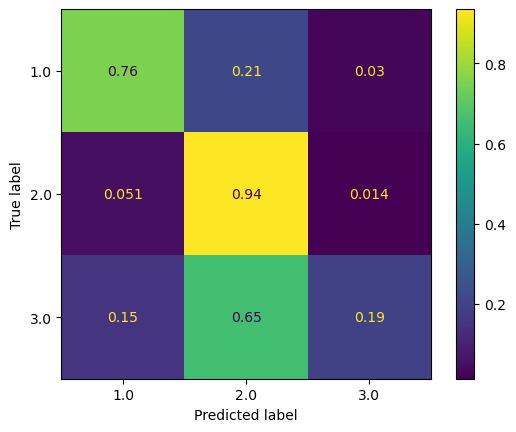

In [16]:
raw_rf = RandomForestClassifier(random_state=1)
train_model(raw_rf, X_train, X_test, y_train, y_test)

In [ ]:
cols = [X_full.columns.get_loc(c) for c in lidar_features]
preprocessor = ColumnTransformer([
    ("scaled_pca", 
      Pipeline([
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12))]),
      cols)],
  remainder="passthrough")

Classification report
               precision    recall  f1-score   support

         1.0       0.65      0.61      0.63       200
         2.0       0.79      0.85      0.82       512
         3.0       0.34      0.23      0.27        84

    accuracy                           0.72       796
   macro avg       0.59      0.56      0.57       796
weighted avg       0.70      0.72      0.71       796

Balanced accuracy score: 0.562297867063492


Pipeline(steps=[('imputer', SimpleImputer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaled_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.85))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('rf', RandomForestClassifier(random_state=1))])

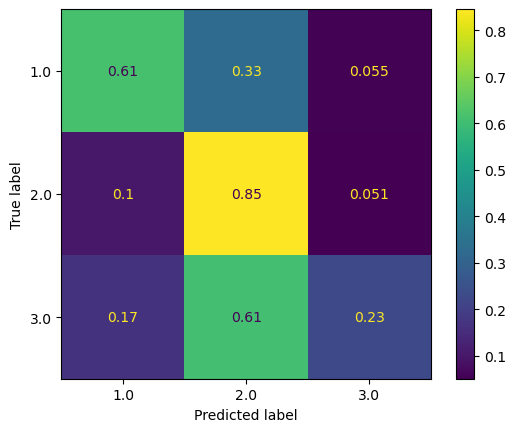

In [19]:
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=1))
])
train_model(preprocess, X_train, X_test, y_train, y_test)

## cross-validation

In [17]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [18]:
#get cv results
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score, average='macro'),
           'f1_macro' : make_scorer(f1_score, average='macro'),
           'balanced_accuracy': make_scorer(balanced_accuracy_score)}

In [19]:
cols = [X_full.columns.get_loc(c) for c in lidar_features]
preprocessor = ColumnTransformer([
    ("scaled_pca", 
      Pipeline([
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12))]),
      cols)],
  remainder="passthrough")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.815) balanced_accuracy: (train=1.000, test=0.668) f1_macro: (train=1.000, test=0.693) precision: (train=0.999, test=0.747) recall: (train=1.000, test=0.668) total time=   1.4s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.808) balanced_accuracy: (train=0.999, test=0.632) f1_macro: (train=0.999, test=0.660) precision: (train=1.000, test=0.726) recall: (train=0.999, test=0.632) total time=   1.3s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.780) balanced_accuracy: (train=0.999, test=0.620) f1_macro: (train=0.

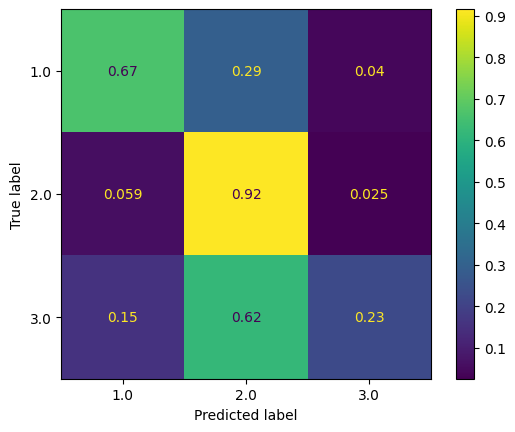

In [20]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit='balanced_accuracy', 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.795) balanced_accuracy: (train=1.000, test=0.611) f1_macro: (train=1.000, test=0.634) precision: (train=1.000, test=0.725) recall: (train=1.000, test=0.611) total time=   1.1s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.806) balanced_accuracy: (train=0.999, test=0.625) f1_macro: (train=0.999, test=0.661) precision: (train=1.000, test=0.758) recall: (train=0.999, test=0.625) total time=   1.2s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.785) balanced_accuracy: (train=0.999, test=0.601) f1_macro: (train=0.

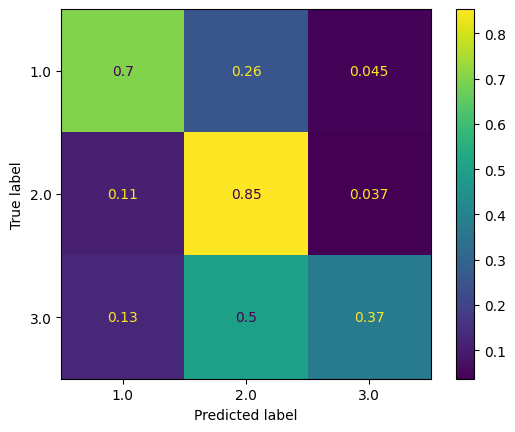

In [21]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(random_state=1, class_weight='balanced'))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.747) balanced_accuracy: (train=1.000, test=0.633) f1_macro: (train=1.000, test=0.623) precision: (train=1.000, test=0.615) recall: (train=1.000, test=0.633) total time=   2.8s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.741) balanced_accuracy: (train=1.000, test=0.642) f1_macro: (train=1.000, test=0.627) precision: (train=1.000, test=0.625) recall: (train=1.000, test=0.642) total time=   2.8s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.748) balanced_accuracy: (train=0.998, test=0.663) f1_macro: (train=0.

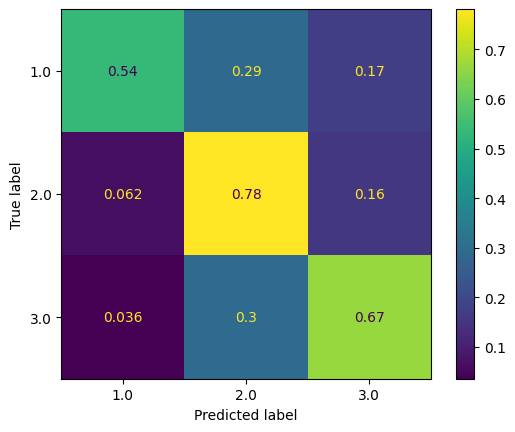

In [22]:
try:
    rf_cv_smote = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("smote", SMOTE(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv_smote,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv_smote = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.767) balanced_accuracy: (train=0.999, test=0.655) f1_macro: (train=0.999, test=0.651) precision: (train=1.000, test=0.650) recall: (train=0.999, test=0.655) total time=   2.7s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.759) balanced_accuracy: (train=1.000, test=0.668) f1_macro: (train=1.000, test=0.650) precision: (train=1.000, test=0.650) recall: (train=1.000, test=0.668) total time=   2.6s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.759) balanced_accuracy: (train=0.999, test=0.670) f1_macro: (train=1.

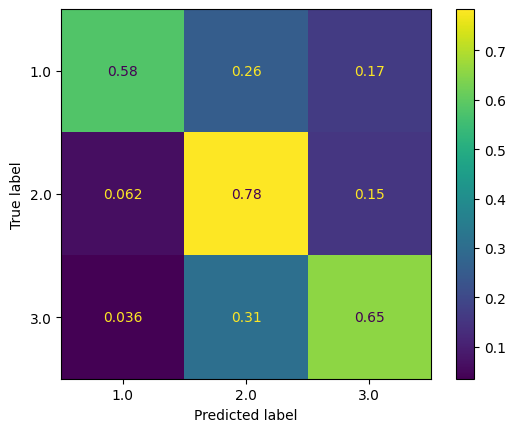

In [23]:
try:
    rf_cv_ad = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("ad", ADASYN(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv_ad,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv_ad = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.774) balanced_accuracy: (train=1.000, test=0.657) f1_macro: (train=1.000, test=0.656) precision: (train=1.000, test=0.655) recall: (train=1.000, test=0.657) total time=   2.7s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.751) balanced_accuracy: (train=1.000, test=0.658) f1_macro: (train=1.000, test=0.642) precision: (train=1.000, test=0.638) recall: (train=1.000, test=0.658) total time=   2.7s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.756) balanced_accuracy: (train=0.999, test=0.652) f1_macro: (train=0.

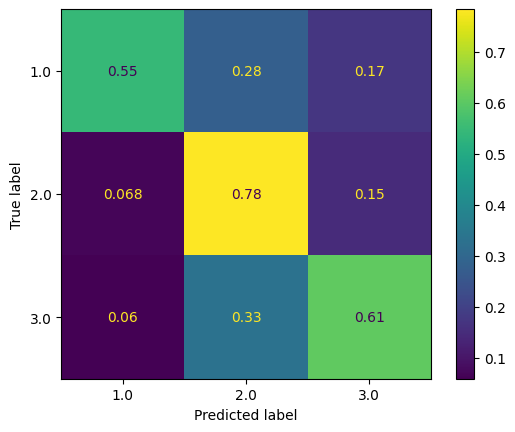

In [24]:
try:
    rf_cv_bsmote = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("bsmote", BorderlineSMOTE(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv_bsmote,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy",
        return_train_score=True
    )
    
    rf_cv_bsmote = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

## MLP

In [32]:
cols = [X_full.columns.get_loc(c) for c in lidar_features]
pca_lidar = ColumnTransformer([
    ("pca", 
      Pipeline([
        ("pca", PCA(n_components=12))]),
      cols)],
  remainder="passthrough")

In [33]:
def train_mlp(pipeline, X_train, X_test, y_train, y_test, groups_train):
    param_grid = {
    "clf__model__hidden_layers": [(64,32,16), (128,64,32)],
    "clf__model__learning_rate": [1e-4],
    "clf__epochs":        [50,100],
    "clf__batch_size":    [32, 64],
    }

    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)

    gscv = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=sgkf,
        scoring=scoring,
        n_jobs=1,
        verbose=2,
        refit="balanced_accuracy",
        return_train_score=True
    )

    gscv.fit(X_train, y_train, groups=groups_train)

    std = gscv.cv_results_["std_test_accuracy"][gscv.best_index_]
    print(f"Best CV BA: {gscv.best_score_:.3f}, ± {std:.3f}")
    print("train score", gscv.cv_results_['mean_train_accuracy'], "vs. cv test score", gscv.cv_results_['mean_test_accuracy'])
    print("Best params:")
    for k, v in gscv.best_params_.items():
        print(f"  {k}: {v}")
    
    mean_f1 = np.mean(gscv.cv_results_["mean_test_f1_macro"])
    std_f1 = np.std(gscv.cv_results_["std_test_f1_macro"])
    mean_ba = np.mean(gscv.cv_results_["mean_test_balanced_accuracy"])
    std_ba = np.std(gscv.cv_results_["std_test_balanced_accuracy"])
    mean_oa = np.mean(gscv.cv_results_["mean_test_accuracy"])
    std_oa = np.std(gscv.cv_results_["std_test_accuracy"])
    print(f"Mean CV accuracy: {mean_oa:.3f}, ± {std_oa:.3f}")
    print(f"Mean CV BA: {mean_ba:.3f}, ± {std_ba:.3f}")
    print(f"Mean CV f1: {mean_f1:.3f}, ± {std_f1:.3f}")

    test_acc = gscv.score(X_test, y_test)
    print(f"Test set accuracy: {test_acc:.3f}")

    best_model = gscv.best_estimator_        
    y_pred     = best_model.predict(X_test)
    print("Classification report\n", classification_report(y_test, y_pred))
    print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

def build_mlp(hidden_layers=(64,32,16), meta=None, **kwargs):
    model = Sequential([
        Input(shape=(meta["n_features_in_"],)),])
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  14.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  12.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.6s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   6.1s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   6.6s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   6.5s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   6.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   6.4s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   6.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   6.2s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.7s
[CV] END clf__batch_size=64,

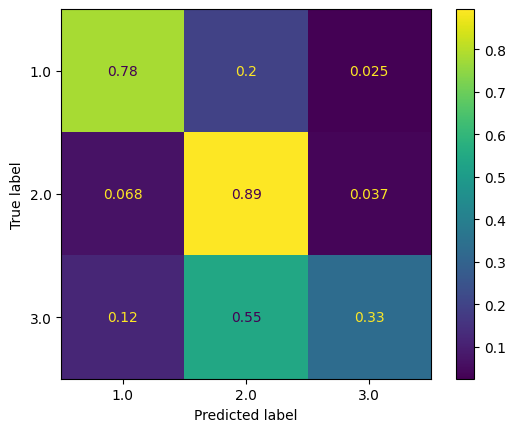

In [34]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train, X_test, y_train, y_test, groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.2s


/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   7.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   7.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   7.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   7.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   7.4s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  12.8s
[CV] END clf__batch_size=32,

/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   4.9s


/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   4.9s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   4.9s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   5.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   5.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   5.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   5.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   5.2s
[CV] END clf__batch_size=64, 

/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   8.9s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   8.8s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   8.8s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.2s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.4s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.3s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.2s
[CV] END clf__batch_siz

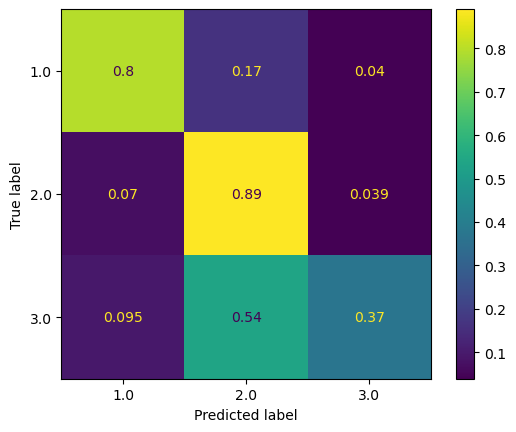

In [32]:
#without vegetation indices
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train, X_test, y_train, y_test, groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   8.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   8.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   8.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   8.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   8.7s
[CV] END clf__batch_size=32, clf

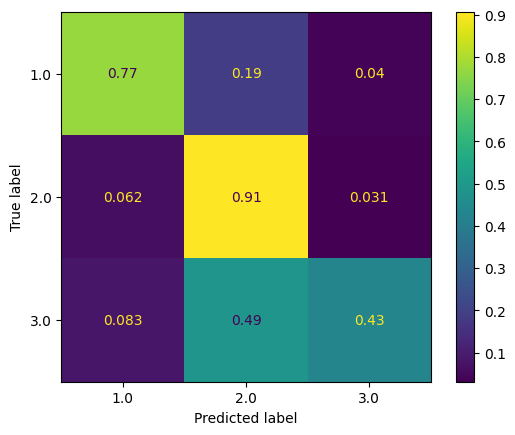

In [41]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train, X_test, y_train, y_test, groups_train)

## Balanced 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

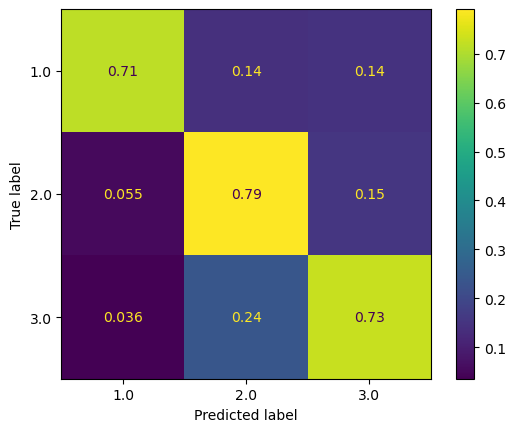

In [34]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv_smote = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("smote", SMOTE(sampling_strategy='minority', random_state=1)),
    ("clf", clf)
])

train_mlp(mlp_cv_smote, X_train, X_test, y_train, y_test, groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   9.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   9.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   9.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   9.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

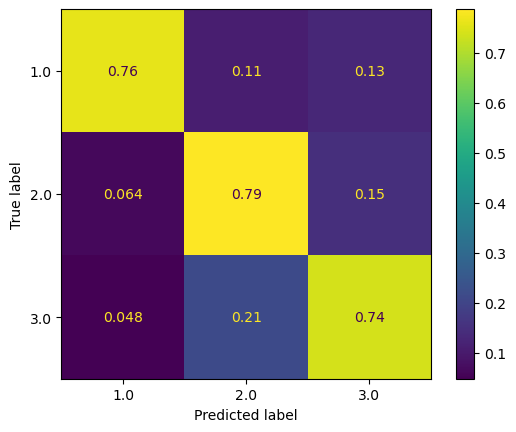

In [35]:
mlp_cv_ad = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("smote", ADASYN(sampling_strategy='minority', random_state=1)),
    ("clf", clf)
])

train_mlp(mlp_cv_ad, X_train, X_test, y_train, y_test, groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

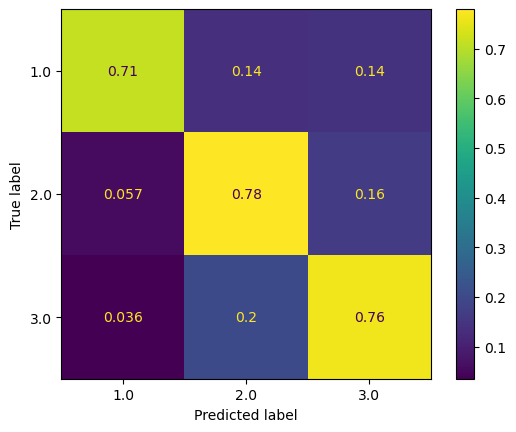

In [36]:
mlp_cv_bsmote = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("bsmote", BorderlineSMOTE(sampling_strategy='minority', random_state=1)),
    ("clf", clf)
])

train_mlp(mlp_cv_bsmote, X_train, X_test, y_train, y_test, groups_train)

In [37]:
end_time = time.time()
end_mem = process.memory_info().rss / (1024 ** 2)  # in MB

print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Start memory usage: {start_mem:.2f} MB")
print(f"End memory usage: {end_mem:.2f} MB")
print(f"Peak memory usage: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024:.2f} MB")

Total execution time: 3171.22 seconds
Start memory usage: 66.23 MB
End memory usage: 3477.90 MB
Peak memory usage: 3711.82 MB
